### Sift descriptor with bag-of-words

---

In this notebook I use sift descriptor to descrive the image, than I use kmeans to cluster this descriptors. The idea is that each cluster will be representing a visual word, if an image is added then the SIFT descriptor will be used to describe the image followed by kmeans prediction that will tell wich word represents each SIFT vector that describes the image.

Than finally I count the ocorrences of each visual word, by doing so, creating an histogram.
 
---

In [ ]:
!gdown 1ybSxo-feGF1yiahBzXM17MT5tW_tK6D6
!gdown 1-0l3CmLIkA6kzSWgVwvDf59JsgbkNHfg

Downloading...
From: https://drive.google.com/uc?id=1ybSxo-feGF1yiahBzXM17MT5tW_tK6D6
To: /content/wider_data_resized.csv
100% 567k/567k [00:00<00:00, 83.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0l3CmLIkA6kzSWgVwvDf59JsgbkNHfg
To: /content/wider_data_resized.zip
100% 467M/467M [00:04<00:00, 99.1MB/s]


In [ ]:
%%capture
!unzip wider_data_resized.zip

In [ ]:
%%capture
!pip install -U opencv-python

In [ ]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from random import randrange
from skimage import io
from PIL import Image 
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt



In [ ]:
df = pd.read_csv('wider_data_resized.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head(1)

,img_location,x0,y0,x1,y2
0,wider_data_resized/0_Parade_marchingband_1_849...,210.46875,114.36823,267.65625,166.00722


In [ ]:
feature_extractor = cv2.SIFT_create()

In [ ]:
L_sift = []

for imagem in tqdm(df['img_location']):
  imagem_data = io.imread(imagem) 
  imagem_data = cv2.cvtColor(imagem_data, cv2.COLOR_BGR2RGB)
  _, sift_vectors = feature_extractor.detectAndCompute(imagem_data, None)
  L_sift.append(sift_vectors)

  0%|          | 0/5757 [00:00<?, ?it/s]

In [ ]:
df['sift'] = L_sift

## Agrupamento dos descritores SIFT para geração de Visual Words

In [ ]:
X_sift = []
for _, row in df.iterrows():
  for sift_vector in row['sift']:
    X_sift.append(sift_vector)

In [ ]:
X_sift = np.array(X_sift)
X_sift.shape

(6596018, 128)

## Agrupamento de descritores

O número de bag of visual words descreverá o número de palavras visuais.

In [ ]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
import numpy as np

In [ ]:
num_visual_words = 512
kmeans = MiniBatchKMeans(n_clusters=num_visual_words, n_init=1, max_iter=20, init='random', verbose=1)
kmeans.fit(X_sift)

In [ ]:
import pickle

filename = 'kmeans_model_for_BOVW_clustering.sav'
pickle.dump(kmeans, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
df_visual_words = pd.DataFrame(X_sift)
df_visual_words.head(1)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,102.0,32.0,24.0,7.0,0.0,0.0,5.0,52.0,132.0,128.0,...,1.0,2.0,17.0,4.0,4.0,4.0,1.0,0.0,2.0,24.0


In [ ]:
df_visual_words['visual_word'] = kmeans.labels_
df_visual_words.head(5)

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,visual_word
0,102.0,32.0,24.0,7.0,0.0,0.0,5.0,52.0,132.0,128.0,...,2.0,17.0,4.0,4.0,4.0,1.0,0.0,2.0,24.0,382
1,92.0,14.0,38.0,126.0,12.0,1.0,1.0,47.0,1.0,14.0,...,10.0,9.0,7.0,45.0,15.0,0.0,0.0,9.0,31.0,11
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,17.0,...,9.0,6.0,57.0,75.0,41.0,32.0,10.0,1.0,2.0,2
3,0.0,1.0,14.0,12.0,24.0,13.0,0.0,0.0,8.0,35.0,...,12.0,10.0,22.0,17.0,14.0,14.0,25.0,6.0,1.0,405
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,49.0,...,17.0,1.0,26.0,137.0,90.0,12.0,11.0,1.0,0.0,89


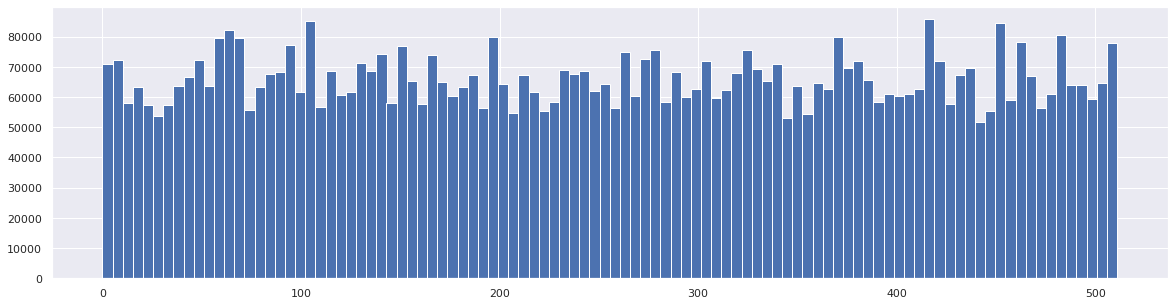

In [ ]:
import seaborn as sns

sns.set_theme()

plt.rcParams["figure.figsize"] = (20,5)
df_visual_words.visual_word.hist(bins=100)

## Now we need to generate the histogram of each image based on the "words" that describes the image

In [ ]:
L_histogram = []
for index,row in tqdm(df.iterrows(),total=len(df)):
  histogram = kmeans.predict(np.array(row['sift']))
  histogram = np.histogram(histogram,num_visual_words)[0]
  L_histogram.append(histogram)

  0%|          | 0/5757 [00:00<?, ?it/s]

In [ ]:
df['visual_words_histogram'] = L_histogram
df.head()

,img_location,x0,y0,x1,y2,sift,visual_words_histogram
0,wider_data_resized/0_Parade_marchingband_1_849...,210.46875,114.368230,267.65625,166.00722,"[[102.0, 32.0, 24.0, 7.0, 0.0, 0.0, 5.0, 52.0,...","[3, 1, 3, 1, 3, 4, 6, 1, 11, 9, 6, 8, 2, 8, 3,..."
1,wider_data_resized/0_Parade_Parade_0_904.jpg,169.21875,32.849160,292.50000,146.48044,"[[13.0, 1.0, 1.0, 86.0, 85.0, 0.0, 0.0, 14.0, ...","[4, 3, 0, 3, 4, 5, 9, 3, 3, 1, 2, 4, 0, 1, 2, ..."
2,wider_data_resized/0_Parade_Parade_0_577.jpg,137.81250,90.966515,351.09375,267.44156,"[[23.0, 2.0, 0.0, 31.0, 142.0, 9.0, 0.0, 3.0, ...","[3, 4, 5, 7, 2, 5, 4, 2, 8, 1, 4, 7, 1, 5, 1, ..."
3,wider_data_resized/0_Parade_Parade_0_883.jpg,249.37500,76.799995,352.03125,208.00000,"[[2.0, 0.0, 0.0, 2.0, 1.0, 7.0, 58.0, 18.0, 43...","[4, 1, 4, 4, 0, 0, 2, 1, 2, 1, 7, 1, 4, 3, 0, ..."
4,wider_data_resized/0_Parade_marchingband_1_873...,205.78125,61.825905,292.50000,148.11041,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0,...","[2, 0, 1, 1, 0, 1, 1, 1, 2, 7, 0, 5, 0, 1, 1, ..."


In [ ]:
df['visual_words_histogram'] = [list(cur_hist) for cur_hist in df['visual_words_histogram']] 

In [ ]:
df[['img_location', 'x0', 'y0', 'x1', 'y2', 'visual_words_histogram']].to_csv('wider_data_with_visual_words.csv', index=False)

In [ ]:
test_df = pd.read_csv('wider_data_with_visual_words.csv')